In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [154]:
pip install hdbscan

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# dependencies
import pandas as pd
import scipy.interpolate as sci_int
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci_stats
import cartopy.crs as ccrs
import geopandas as gpd

from sklearn.utils import resample
from sklearn.cluster import KMeans
import hdbscan

In [3]:
# import undrogued data
beach = pd.read_csv('undrogued_beach.csv')
unbeach = pd.read_csv('undrogued_unbeach.csv')

In [43]:
last_points_input

,id,time,lat,lon,ve,vn
0,101509,1331078400,13.71750,124.71663,-0.1732,-0.0036
102,101510,1328504400,22.35016,120.59885,0.0015,0.1483
120,101512,1328720400,20.67819,121.05971,-0.3422,1.1730
143,101519,1330207200,24.75619,125.47094,0.0689,-0.2081
3824,101534,1345708800,8.58603,-13.21257,0.1051,-0.0605
...,...,...,...,...,...,...
23060933,9915124,930420000,65.89437,-24.21946,-0.0359,-0.1442
23060957,9915757,937522800,37.42537,129.32630,0.0116,0.0080
23061290,9915941,937814400,38.26993,128.64050,-0.1522,-0.5818
23068083,9917894,995828400,-15.46437,167.69762,0.0298,-0.0163


In [37]:
# get beaching points
last_points_input = beach.drop_duplicates(subset='id', keep='last')
cluster_input = last_points_input[['lat', 'lon']].values

In [38]:
num_clusters = 18

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(cluster_input)

KMeans(n_clusters=18)

In [39]:
# Get cluster labels
labels = kmeans.labels_

# Add cluster labels to the dataframe
last_points['cluster'] = labels

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


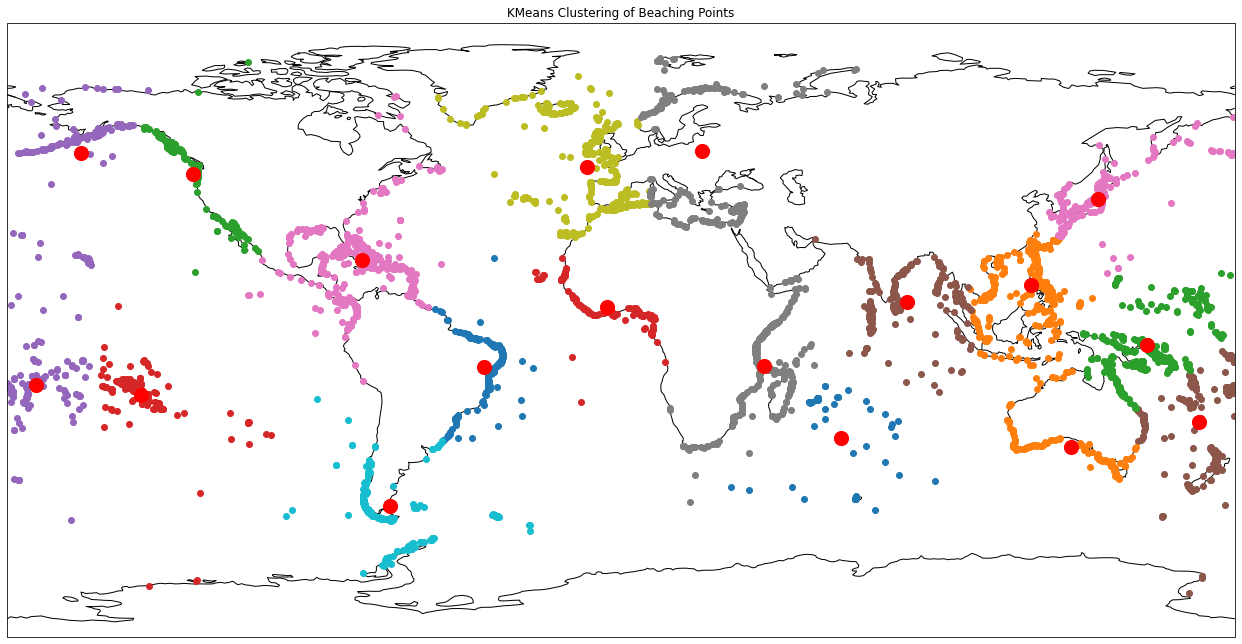

In [40]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10
for cluster in range(num_clusters):
    cluster_points = last_points[last_points['cluster'] == cluster]
    plt.scatter(cluster_points['lon'], cluster_points['lat'], label=f'Cluster {cluster + 1}')

plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], marker='o', s=200, c='r', label='Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KMeans Clustering of Beaching Points')
#plt.legend()
plt.show()

# HDBSCAN Clustering

In [41]:
min_cluster_size = 40
hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
hdb.fit(cluster_input)
labels = hdb.labels_

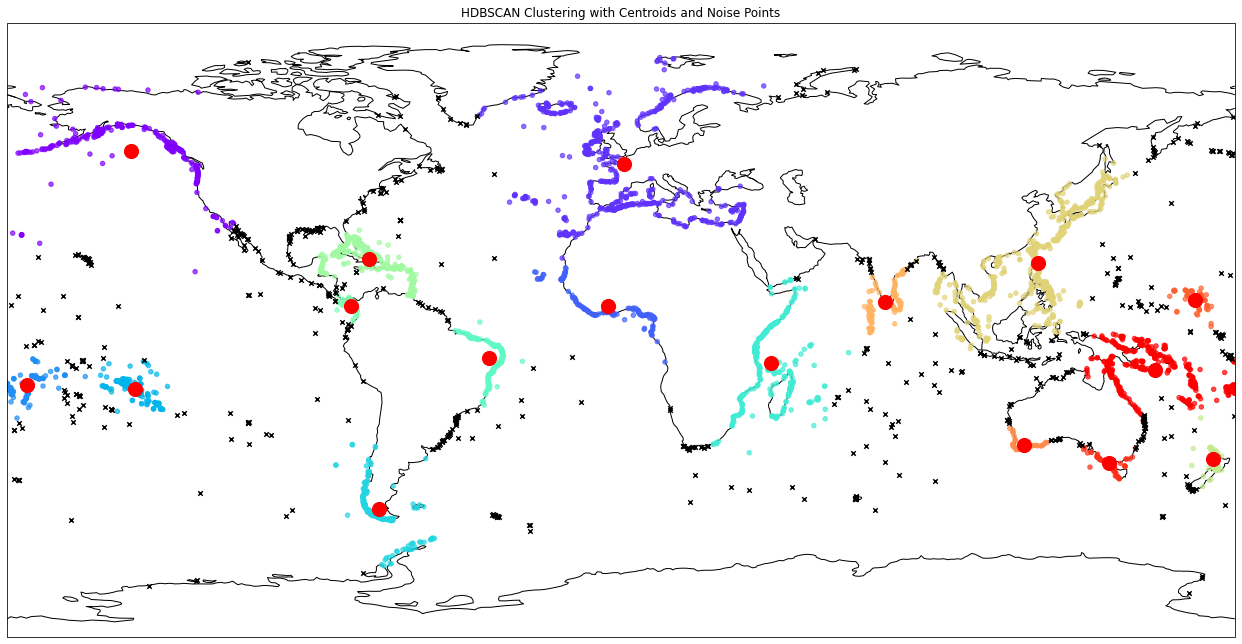

In [42]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

# Plot points
scatter = ax.scatter(cluster_input[labels != -1, 1], cluster_input[labels != -1, 0], c=labels[labels != -1], cmap='rainbow', alpha=0.7, s=20)

# Plot centroids
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id != -1:
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        ax.scatter(centroid[1], centroid[0], marker='o', color='red', s=200, label=f'Cluster {cluster_id} Centroid')

# Plot noise points as small 'x'
noise_mask = (labels == -1)
ax.scatter(cluster_input[noise_mask, 1], cluster_input[noise_mask, 0], marker='x', color='black', s=20, label='Noise Points')

#ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('HDBSCAN Clustering with Centroids and Noise Points')
plt.show()

In [97]:
# organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

# remove unclustered 'noise'
cluster_df_filtered = cluster_df[cluster_df['HDBSCAN'] != -1]

# bootstrap with replacement
num_trajectories = 1000
bootstrapped_df = cluster_df_filtered.sample(n=num_trajectories, replace=True, random_state=42)
bootstrapped_df.reset_index(drop=True, inplace=True)


# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), bootstrapped_df.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(bootstrapped_df['id'])]

In [98]:
beach_clusters

,id,time,lat,lon,ve,vn,HDBSCAN
23395,7896,1003536000,24.12491,-75.27294,0.1853,0.3031,9.0
23396,7896,1003536000,24.12491,-75.27294,0.1853,0.3031,9.0
23509,13696,1073260800,55.76729,-25.98953,0.0598,0.1903,1.0
23510,13696,1073260800,55.76729,-25.98953,0.0598,0.1903,1.0
23511,13696,1073260800,55.76729,-25.98953,0.0598,0.1903,1.0
...,...,...,...,...,...,...,...
23862617,300234067906400,1586127600,71.55837,41.78903,0.1612,-0.1025,1.0
23862618,300234067906400,1586131200,71.55493,41.80489,0.1494,-0.1119,1.0
23862619,300234067906400,1586134800,71.55113,41.82096,0.1604,-0.1209,1.0
23862620,300234067906400,1586138400,71.54688,41.83853,0.1875,-0.1457,1.0


### let's plot the trajectories of these clusters

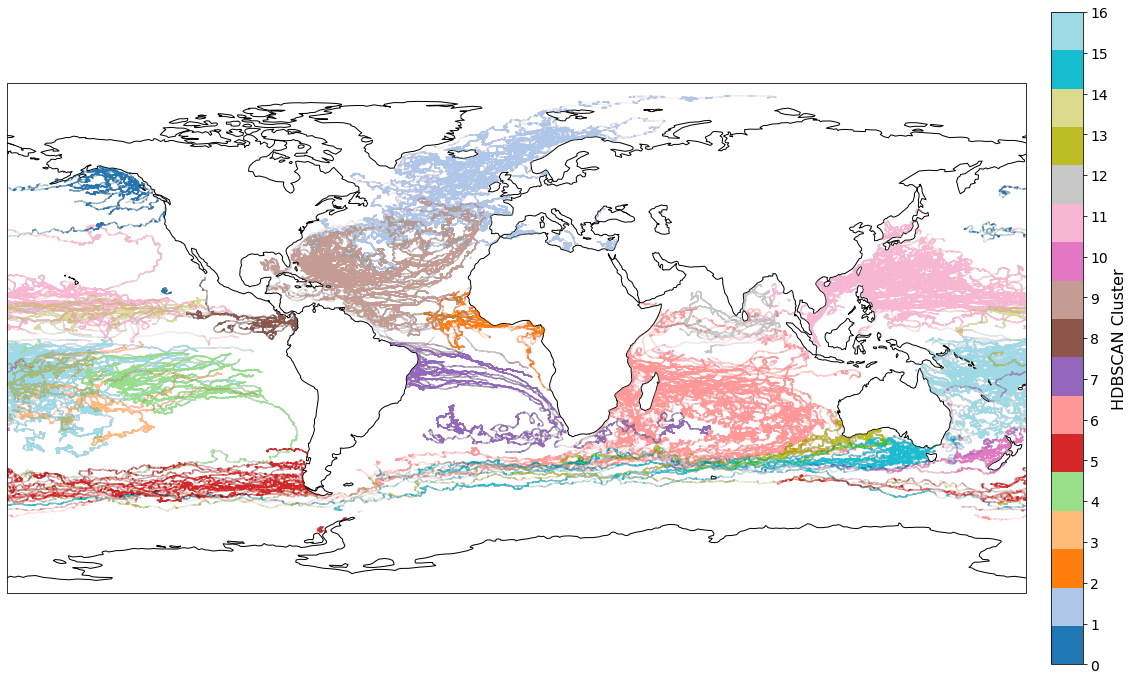

In [99]:
num_clusters_HDSBSCAN = len(np.unique(beach_clusters_filtered['HDBSCAN']))

# Create a colormap with distinct colors for each cluster
colors_HDBSCAN = plt.cm.get_cmap('tab20', num_clusters_HDSBSCAN)

point_size = 0.00005


# Plotting code
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

#first_cluster_df = beach_clusters[beach_clusters['HDBSCAN'] == 1]

# Scatter plot with colors based on HDBSCAN labels
plt.scatter(
    beach_clusters['lon'],
    beach_clusters['lat'],
    marker='o',
    c=beach_clusters['HDBSCAN'],
    cmap=colors_HDBSCAN,
    s=point_size
)



# Add colorbar
cbar = plt.colorbar(orientation='vertical', pad=0.02, ticks=np.arange(num_clusters_HDSBSCAN))
cbar.set_label('HDBSCAN Cluster', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.show()